# Cleaning Data
From https://github.com/dleebrown/MissingDataImputation

Crowdsourced wisdom suggests that around **60% of a data scientist's time is spent cleaning, preparing, and exploring data!**

There are many cases where we have to work with messy, incomplete, or plain wrong data:
* Manually entered information
* Shifting collection methods with improper changelogs/documentation
* Exploratory/feasibility projects (and data challenges!)
* Truly missing data

Correctly identifying these cases and addressing them appropriately is key to executing a data science project successfuly - the mantra "garbage in, garbage out" can easily be shown to hold true and many ML and statistical algorithms will return poor/biased results unless due diligence has been carried out with the data.

In this notebook I will walk through some common techniques for diagnosing and cleaning data:

* using ``df.dtypes``, ``df.describe``, and ``df.unique`` to quickly identify data flaws
* detecting outliers using distributions
* cleaning categorical variables
* identifying missing values using the ``missingno`` package
* imputing missing values using statistical techniques


Imputation discussion adapted from an excellent workshop given by https://github.com/cluck28/MissingDataImputation

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
#Missingno is a package to visualize missing data
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
sns.set_style("darkgrid")
#Load data
df = pd.read_csv('nba_2016_2017_100_edit.csv')

## Dataset
We have a dataset consisting of a sample of 2016-2017 NBA players with some key metrics given in 12 columns:
* PLAYER_ID: (int) Unique ID identifying each player
* FAVORITE_FOOD: (str) Results from a misguided graduate student's survey of whether NBA players prefer pizza, pasta, or peppers
* PLAYER_NAME: (str) Player Names
* TEAM_ABBREVIATION: (str) 3-letter team abbreviations
* AGE, GP, W, L: (int) Ages, goal percentages, wins, losses for each player
* OFF_RATING, DEF_RATING, SALARY_MILLIONS, PTS: (float) Offense and defense ratings, salary, and points/game stats


Typically some descriptive documentation accompanies datasets, but often this documentation is incomplete or inaccurate. It's important to adopt the mantra "trust, but verify" when confronted with a new dataset and do your due EDA diligence.


### Simple Diagnostics: df.ftypes and df.describe

Pandas has built-in methods that allow common data issues to be caught easily. First, ``df.dtypes`` gives a quick indication of column types - useful for identifying unexpected strings!

In [34]:
df.dtypes

PLAYER_ID              int64
FAVORITE_FOOD         object
PLAYER_NAME           object
TEAM_ABBREVIATION     object
AGE                    int64
GP                     int64
W                    float64
L                      int64
OFF_RATING           float64
DEF_RATING            object
SALARY_MILLIONS      float64
PTS                  float64
dtype: object

Everything checks out except the W column is listed as float instead of int. This is likely okay, but more worryingly we see that DEF_RATING is listed as type object (the documentation indicates float), suggesting there may be strings present. 

The problem is that pandas has automatically converted every entry in the column to type string - we can get around this to identify the "true" strings by indexing by the results of a pd.to_numeric with coerce on. 

In [35]:
true_strings = pd.to_numeric(df['DEF_RATING'], errors='coerce').isnull()

print('The number of true strings in DEF_RATING is', df.DEF_RATING[true_strings].count())
print('The unique strings in DEF_RATING are ', df.DEF_RATING[true_strings].unique())

The number of true strings in DEF_RATING is 18
The unique strings in DEF_RATING are  ['none']


We see that 18 players are missing defense ratings with corresponding entry of 'none' (possibly someone trying to be helpful when entering data). We can go ahead and replace these values with np.nan:

In [36]:
df['DEF_RATING'] = pd.to_numeric(df['DEF_RATING'], errors='coerce')

``df.describe`` is another useful diagnostic for identifying flaws in numerical values:

In [37]:
df.describe()

,PLAYER_ID,AGE,GP,W,L,OFF_RATING,DEF_RATING,SALARY_MILLIONS,PTS
count,1.000000e+02,100.000000,100.000000,77.000000,100.000000,100.000000,82.000000,81.000000,100.000000
mean,3.026027e+05,27.510000,62.440000,32.753247,29.420000,117.728000,105.986585,10.734469,15.174200
std,4.237828e+05,3.935066,21.261869,16.153178,12.726478,101.083884,4.297710,8.740211,7.319374
min,1.717000e+03,20.000000,2.000000,0.000000,1.000000,86.800000,93.000000,0.310000,1.500000
25%,2.011780e+05,25.000000,55.500000,23.000000,21.000000,104.275000,103.775000,2.240000,9.225000
50%,2.023305e+05,27.000000,72.000000,36.000000,30.500000,107.150000,106.000000,9.560000,14.550000
75%,2.034582e+05,30.000000,77.000000,44.000000,37.250000,110.275000,108.400000,18.310000,20.650000
max,1.627848e+06,39.000000,82.000000,65.000000,55.000000,1117.200000,118.300000,30.960000,31.600000


Looking at the summary statistics, there's clearly something off with the offense rating column - possibly a single outlier due to some mistyping. Looking at the distribution of offense ratings can confirm this: 



/Users/donald/anaconda3/envs/condaenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


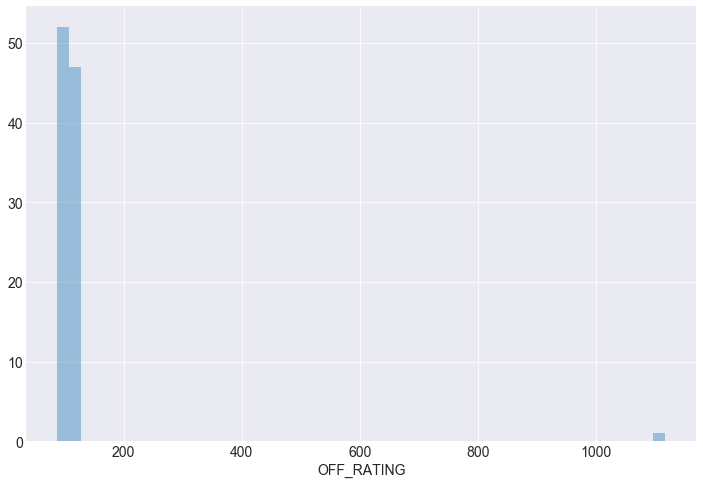

In [38]:
plt.figure(figsize=(12,8))
sns.distplot(df.OFF_RATING, kde=False)

We can remove outliers easily using a lambda function:

/Users/donald/anaconda3/envs/condaenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


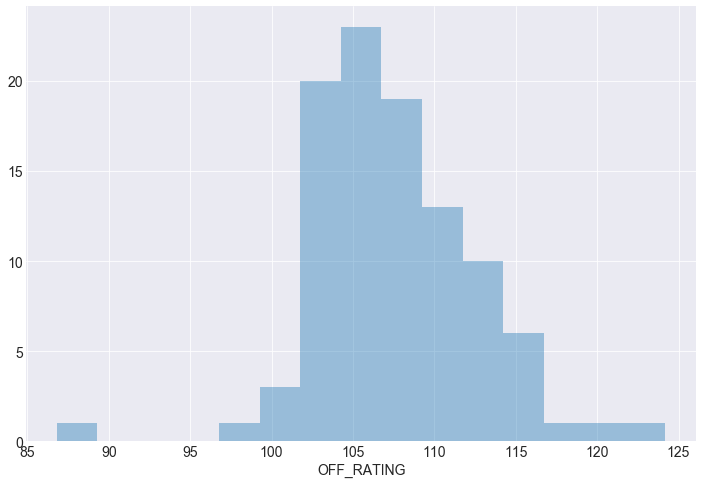

In [39]:
df['OFF_RATING'] = df.OFF_RATING.apply(lambda x: np.nan if x > 200.0 else x)

plt.figure(figsize=(12,8))
sns.distplot(df.OFF_RATING.dropna(), kde=False)

### Categorical Variables

When dealing with categorical variables, it's useful to double check to make sure there aren't any non-canonical entries using ``df.unique``:

In [40]:
df['FAVORITE_FOOD'].unique()

array(['Pizza', 'Pasta', 'Peppers', 'Peepers', '{izza', 'Pppers', 'Padta'],
      dtype=object)

We can often infer what the non-canonical variables should be - ``df.str.replace`` is our friend here:

In [41]:
df['FAVORITE_FOOD'] = df['FAVORITE_FOOD'].str.replace(r'(^.*pers$)', 'Peppers') # you can do this with regex
df['FAVORITE_FOOD'] = df['FAVORITE_FOOD'].str.replace('{izza', 'Pizza') # or the old-fashioned way
df['FAVORITE_FOOD'] = df['FAVORITE_FOOD'].str.replace('Padta', 'Pasta')

In [42]:
df['FAVORITE_FOOD'].unique()

array(['Pizza', 'Pasta', 'Peppers'], dtype=object)

### Missing Values 

For missing values, enter ``missingno``, an extremely useful package for visualizing missing entries - it detects instances of np.nan in pandas DataFrames. 

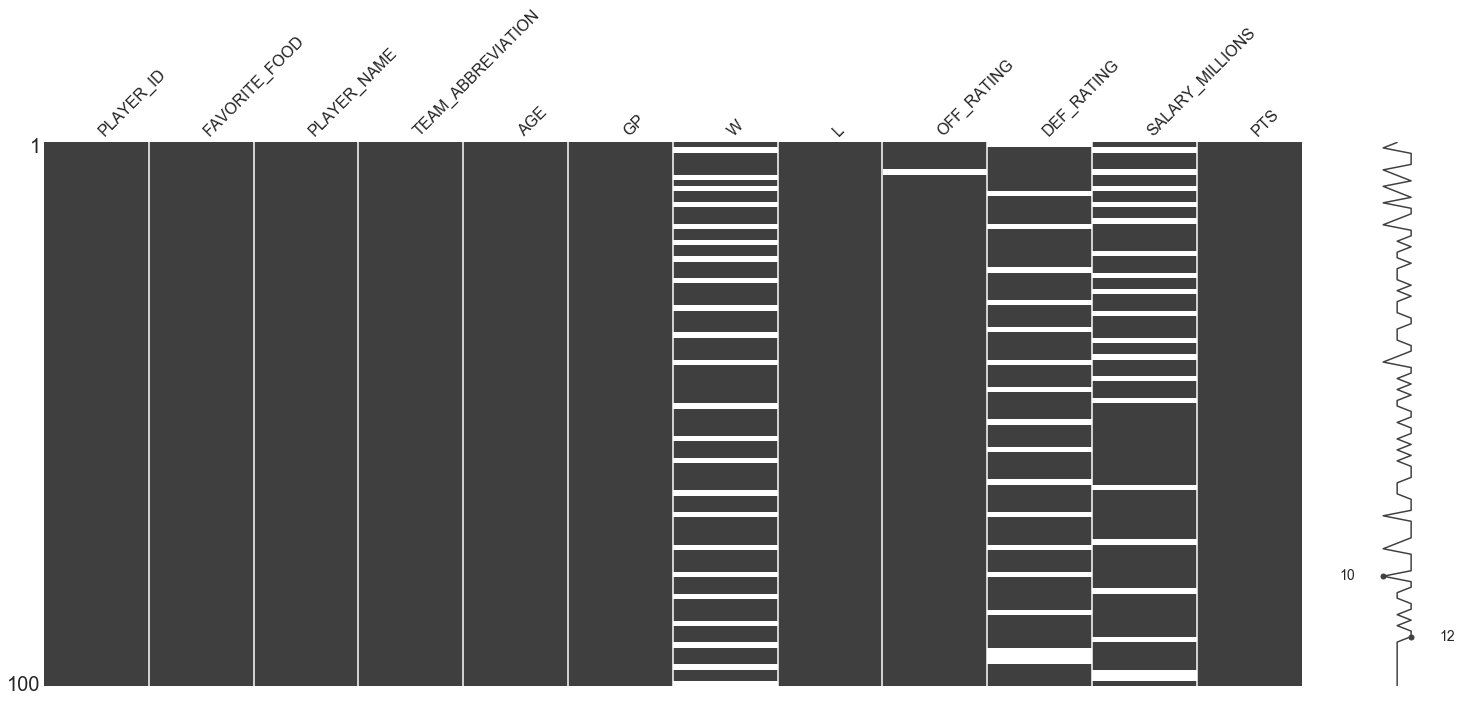

In [43]:
msno.matrix(df)

We can see that a lot of win and salary info is missing, as well as the offense rating we converted earlier. 

Missingno also provides a quick bar chart visualization to see how much data is missing from each column.

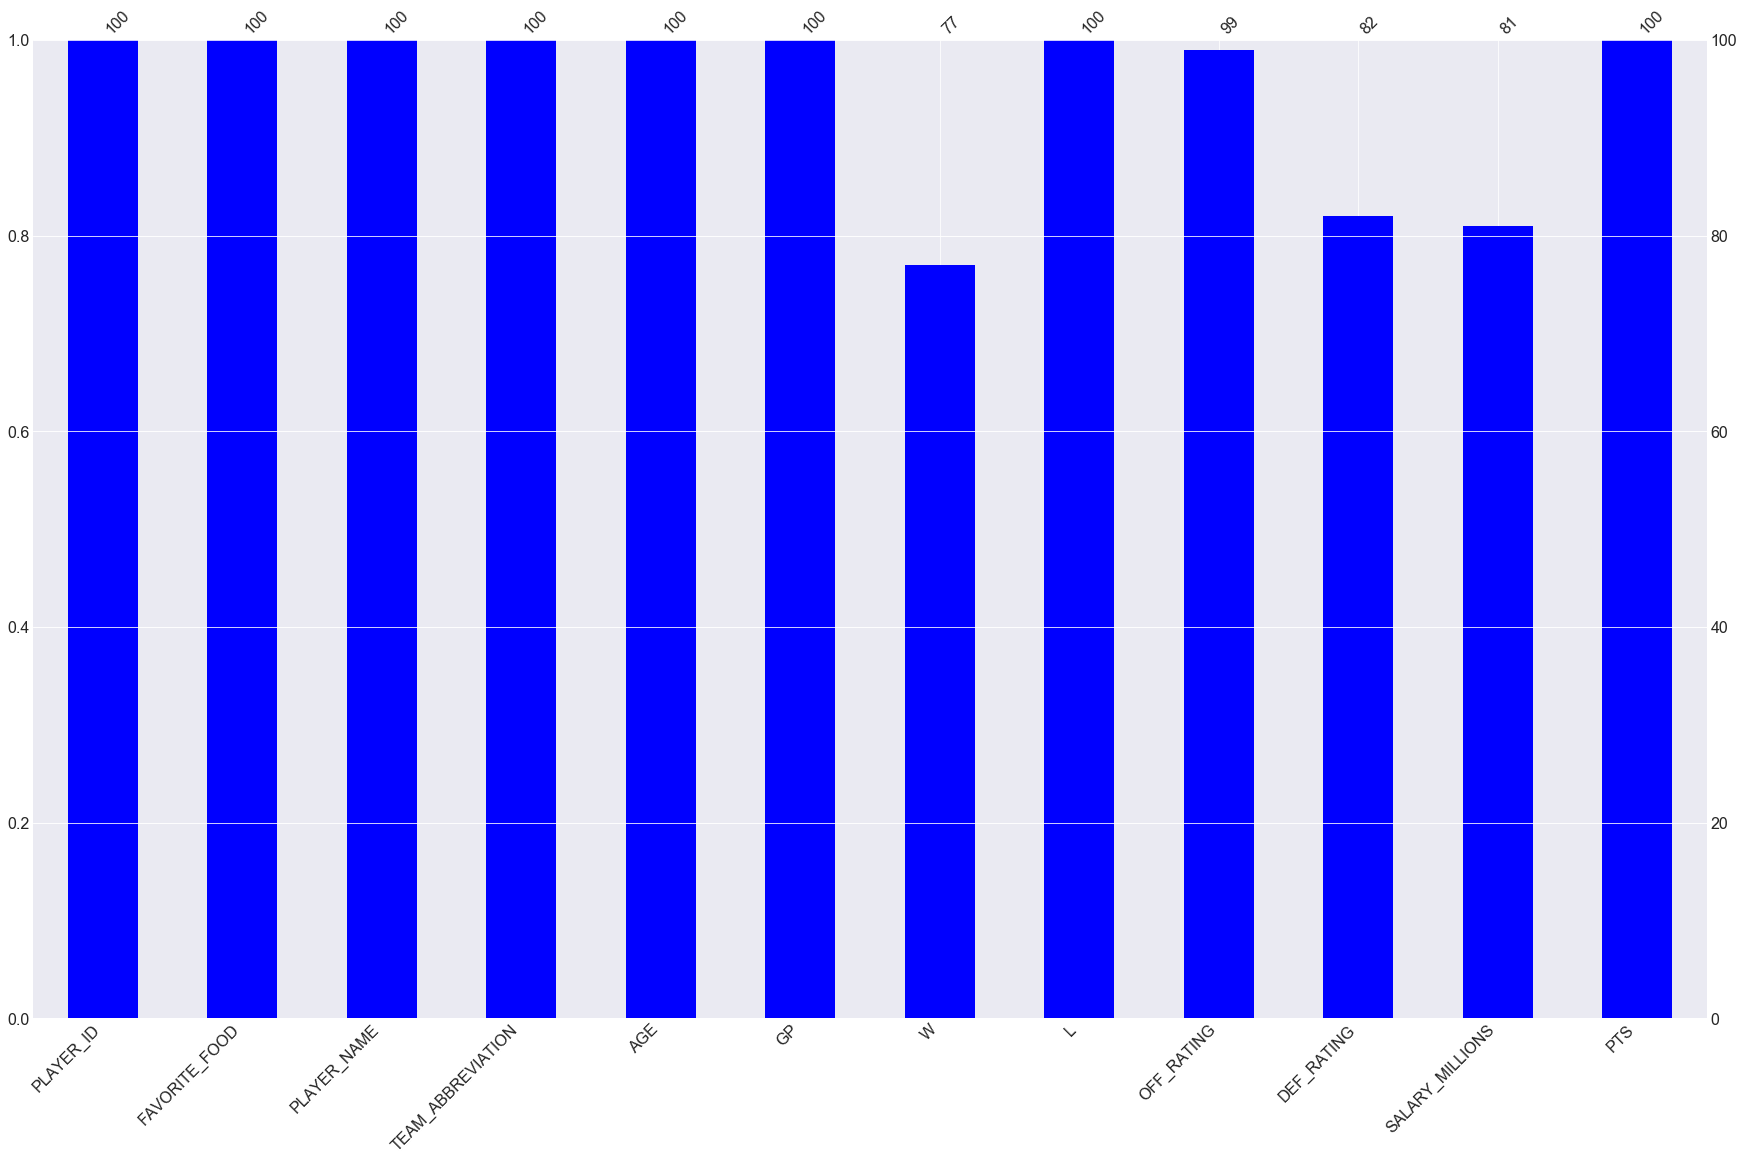

In [44]:
msno.bar(df, color="blue", figsize=(30,18))

Now that we know where data is missing, we have a few options:

* **Case Deletion.** Drop rows with missing data using ``df.dropna`` - this may be appropriate for OFF_RATING, since only 1 point would be dropped
* **Imputation.** Impute missing values - this may be appropriate for the other columns, since ~20% of entries are missing.
* **Do nothing.** This is a good option if we don't plan on using that column in our analysis. 


### Case Deletion

Let's drop the missing offense rating. 

In [45]:
df = df.dropna(subset=['OFF_RATING'])

### Imputation

When trying to impute values, it can be useful to see if there are correlations between missing values and existing ones for each player - ``missingno`` provides convenient functionality for doing this:

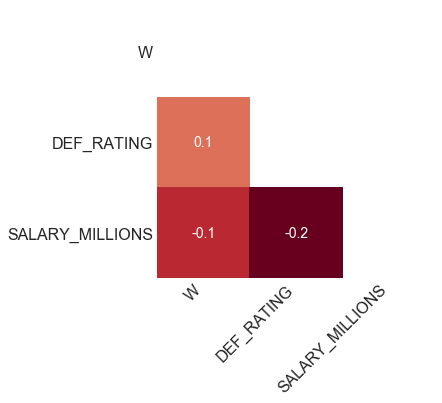

In [46]:
msno.heatmap(df, figsize=(5,5))

Here we look for correlations between instances of missing data. In this data the instances of missing data appear uncorrelated with each other. Here a score of -1 means that when one point is missing the other is not missing, while a score of 1 means that when one point is missing the other is also missing.

Data can be imputed using statistical measures or using regression.

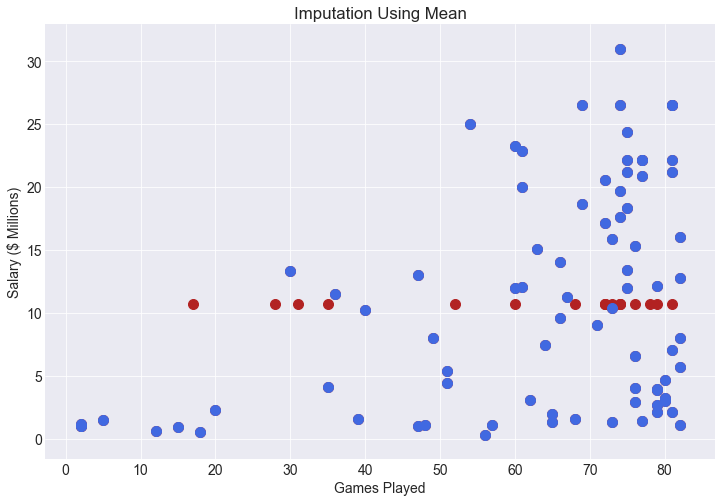

In [47]:
impute = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
salary = df['SALARY_MILLIONS'].values
gp = df['GP'].values
salary_mean = impute.fit_transform(salary.reshape(-1,1)).reshape(1,-1)[0]
plt.figure(figsize=(12,8))
plt.scatter(gp,salary_mean,c='FireBrick', s=100)
plt.scatter(gp,salary,c='RoyalBlue', s=100)
plt.xlabel('Games Played')
plt.ylabel('Salary ($ Millions)')
plt.title('Imputation Using Mean')
plt.show()

<h2>Machine Learning Based Imputation</h2>
Data can be imputed using machine learning based models like k-Nearest Neighbors. k-NN is a simple algorithm that uses the k nearest points to a data point with missing value to impute the missing value. For example, in the case of missing class imputation, the k nearest neighbors form a "voting system" to determine the class of the missing value.

Naturally, k-NN requires some adjustment in the case of highly imbalanced classes.

Here, we'd like to know if a player is above or below average on defense, but some players are missing defensive ratings - we can use k-NN to impute above/below average status on defense, based on offensive rating and points. 

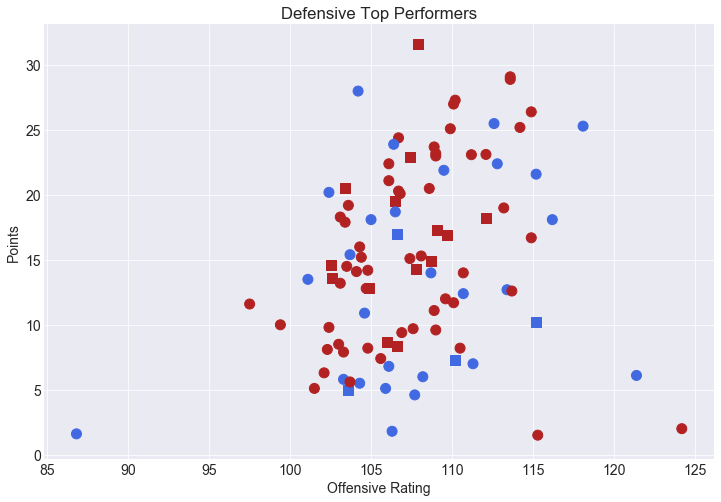

In [48]:
#Turn defensive ratings into class labels
df_class = df[['OFF_RATING','DEF_RATING','PTS']].dropna()
offensive_rating = df_class['OFF_RATING'].values
defensive_rating = df_class['DEF_RATING'].values
points = df_class['PTS'].values
defensive_class = []
for i in range(len(offensive_rating)):
    if defensive_rating[i] > 105:
        defensive_class.append('FireBrick')
    elif defensive_rating[i] <= 105:
        defensive_class.append('RoyalBlue')

classifier = KNeighborsClassifier(n_neighbors=3)
class_result = classifier.fit(np.stack((offensive_rating,points),axis=1),defensive_class)
#Find missing data
missing_def_rating = df[df['DEF_RATING'].isnull()][['OFF_RATING','PTS']].values
#Predict
predicted_def_rating = class_result.predict(missing_def_rating)
plt.figure(figsize=(12,8))
plt.scatter(missing_def_rating[:,0],missing_def_rating[:,1],c=predicted_def_rating,s=100, marker='s')
plt.scatter(offensive_rating,points,c=defensive_class, s=100)
plt.title('Defensive Top Performers')
plt.xlabel('Offensive Rating')
plt.ylabel('Points')
plt.show()

In this plot the squares represent points with class labels predicted by their nearest neighbours. Blue points are below average defensive rankings while Red points are above average defensive rankings.

### Multiple Imputation
There are some python packages that will do multiple imputation for us. In particular they apply the <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/">MICE</a> (Multiple Imputation by Chained Equations) algorithm. Statsmodels has an implementation of the MICE algorithm that can be used as well. 

The MICE algorithm essentially determines missing values via an iterative regression on one or more other parameters. The basic steps to impute missing values of Y, where Y is some variable, using X, a collection of other variables, is:

* Replace all missing values of Y with simple imputation (e.g., mean value)
* Reset one of the imputed Y values to missing
* Train a regression model using X with Y as a target
* Impute the missing Y value using the regression model
* Repeat this for all other originally missing values of Y
* With the new imputed values of Y, repeat the process, resetting one of the Y values to missing and regressing on X
* Iterate until convergence

The MICE algorithm works well when values are randomly missing (i.e. whether or not they are missing is not dependent on hidden variables); otherwise imputed values can be biased. 

/Users/donald/anaconda3/envs/condaenv/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: MICE
=============================================================
Method:              MICE             Sample size:      99   
Model:               OLS              Scale             67.50
Dependent variable:  SALARY_MILLIONS  Num. imputations  10   
-------------------------------------------------------------
          Coef.  Std.Err.   t    P>|t|   [0.025 0.975]  FMI  
-------------------------------------------------------------
Intercept 0.6858   2.7488 0.2495 0.8030 -4.7017 6.0734 0.1314
GP        0.1645   0.0407 4.0376 0.0001  0.0846 0.2443 0.0912
=============================================================

"""

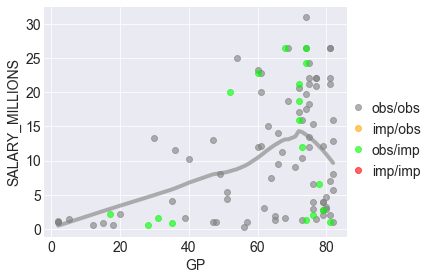

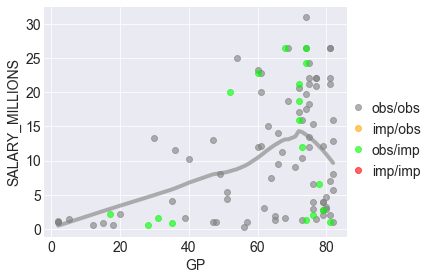

In [49]:
from statsmodels.imputation import mice
import statsmodels as sm
#Create mice data instance
imp = mice.MICEData(df[['GP','SALARY_MILLIONS']])
#Linear model
fml = 'SALARY_MILLIONS ~ GP'
#Build MICE pipeline
out = mice.MICE(fml, sm.regression.linear_model.OLS, imp)
#Fit with burn in of 3 and 10 imputations
results = out.fit(3,10)
#Output results
display(results.summary())
#plot
imp.plot_bivariate('GP','SALARY_MILLIONS')